# Load data and python libraries

In [1]:
%matplotlib inline 

import warnings
warnings.filterwarnings('ignore')

# topic modeling libraries
from gensim import models, corpora
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis.gensim 

# data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# progress meter for loops
from tqdm.notebook import tqdm_notebook,tnrange,tqdm

# supporting libraries
import pickle
import numpy as np
import pandas as pd
pd.set_option('max_colwidth',100)

In [2]:
# file location of the cleaned data frame
input_folder = './transition_files/'
output_folder = './output/'

file_name = 'for_topic_modeling.pickle'

In [3]:
# load data
with open(input_folder + file_name, 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    df_data = pickle.load(f)
    
# display first row of the data frame
df_data.tail(1).T

,272241
Hotel_ID,420
average_rating,4.5
hotel_star,3
individual_ratings,5
review_content,"I was in San Antonio for a wedding during the July 4th weekend. Due to an AA meeting, all the ro..."
review_time,Reviewed 23 July 2010
review_title,Great Hotel; new and spacious rooms with a lot of extras
quarter,Q3
day_of_week,Friday
year,2010


In [4]:
#select only negative ratings
print ("Data size before the filter:", len(df_data))
df_data = df_data[df_data['individual_ratings'].isin([1,2])]
print ("Data size after the filter:", len(df_data))

Data size before the filter: 234404
Data size after the filter: 28742


# Create document-term matrix for the LDA model 

In [5]:
# create a vocabulary for the LDA model 
dictionary = corpora.Dictionary(df_data['selected_list_of_lemmas'])

In [6]:
print('Number of texts processed: ', dictionary.num_docs)
print('Number of extracted lemmas: ', len(dictionary.token2id))
print('\nEach text is represented by list of ', len(dictionary.token2id), 
      " tuples: \n\t\t(lemma's index in bag-of-words dictionary, lemma's term frequency)")

Number of texts processed:  28742
Number of extracted lemmas:  13418

Each text is represented by list of  13418  tuples: 
		(lemma's index in bag-of-words dictionary, lemma's term frequency)


In [7]:
# count the number of occurrences of each distinct token in each document
df_data['doc2bow'] = df_data['selected_list_of_lemmas'].apply(lambda x: dictionary.doc2bow(x))
df_data[['selected_list_of_lemmas','doc2bow']].head()

,selected_list_of_lemmas,doc2bow
16,"[filthy, condescending, season, world, par, sport, tournament, confirmation, email, puzzle, unwi...","[(0, 2), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1..."
25,"[warning, massive, construction, warning, construction, obnoxious, complain, obnoxious, consider...","[(13, 1), (14, 1), (15, 1), (16, 1), (17, 2), (18, 1), (19, 1), (20, 1), (21, 1), (22, 2), (23, ..."
40,"[departure, possible, ruin, mid, doctor, cancer, unload, unload, self, roll, cart, bellman, chat...","[(27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, ..."
44,"[spectacularly, overpriced, upwards, bank, brown, garden, setting, appearance, spectacular, exce...","[(60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, ..."
64,[imagine],"[(105, 1)]"


In [8]:
# create document-term matrix for LDA
doc_term_matrix = list(df_data['doc2bow'].values)

# Estimate the number of topics in a corpus (through topic coherence)

To construct LDA topic model we need to find suitable number of topics (parameter of the LDA model).
<br> Below are the steps of using grid search for the parameter value in the range [3;25]

In general, higher the number of topics chosen for the LDA model, more narrow the space of topic words.
For example, instead of covering hotel decor a topic might cover only decor of hotels entrances.

Coherence score is a loose measure of how words in a topic are related to each other.
<br>Higher the score better estimated coherence.

Since the model has probabilistic nature, selecting number of topics is more art than science.
<br>I prefer to test different numbers and see whether clusters of words make sense.

Interactive visualization tool gives you the ability to see and asses the quality of the topic modeling.
In general, it is preferred that topics (bubbles on the pyLDAvis plot) are well spread on the plot area and have little intersections.
You might need to have several iterations before you settle on the number of topics.

In [ ]:
# Evaluating performance of LDA parameter "number of topics" through grid search 
# this step will take time (<1 hour on my computer)

LDA = models.LdaMulticore
num_topics_list = np.arange(3,25)

coherenceList_cv = []


# for each number of topics calculate Coherence Score
for num_topics in tqdm(num_topics_list):
    #LDA model
    lda= LDA(corpus=doc_term_matrix, num_topics=num_topics, id2word = dictionary, 
             passes=20,chunksize=4000,random_state=3,workers=2)
    
    #C_v coherence score 
    #(you can find different score performance evaluation here http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf)
    cm_cv = CoherenceModel(model=lda, corpus=doc_term_matrix,
                           texts=df_data['selected_list_of_lemmas'], dictionary=dictionary, coherence='c_v')
    
    #save model coherence value for the plot
    coherenceList_cv.append(cm_cv.get_coherence())

In [ ]:
#plot estimated Coherence Score by each topic
df_plot = pd.DataFrame({'Number of topics':num_topics_list,
                         'Coherence Score':coherenceList_cv})
f, ax = plt.subplots(figsize=(10, 5))
plt.style.use('seaborn-whitegrid')

sns.set_context("notebook", font_scale=1.1, rc={"lines.linewidth": 1.5})
sns.pointplot(x ='Number of topics', y = 'Coherence Score', data=df_plot)

plt.axhline(y=0.547)

ax.grid(True, ls='--', alpha=0.5)
plt.title('Topic Coherence\n  C_v Score', y=1.05, fontsize=18)

Many practitioners choose number of topics that corresponds or close to the smallest number with the highest coherence score when the plot is flattening out or fluctuates around some level.
<br>In our case it is 0.547 and the closest number of topics is 10 (8 also might be a good choice).

# Define LDA model

In [9]:
# define the model with chosen number of topics
num_topics = 10


LDA = models.LdaMulticore
result_lda_model= LDA(corpus=doc_term_matrix, 
               num_topics=num_topics,
               id2word = dictionary, 
               passes=20,
               chunksize=4000,
               random_state=3)

##### Interactive visualization of topics using pyLDAviz

In [10]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(result_lda_model, doc_term_matrix, dictionary,sort_topics=False)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.022255 -0.063825       1        1   5.871687
1     -0.003965 -0.075636       2        1   9.339295
2     -0.047921  0.112761       3        1   6.324033
3     -0.138506  0.080966       4        1  16.403316
4      0.152005  0.030625       5        1  10.973414
5      0.133569  0.020068       6        1  15.671571
6     -0.074965 -0.075708       7        1   7.216591
7      0.078672  0.000585       8        1   7.950247
8     -0.097126 -0.054232       9        1   8.297444
9     -0.024018  0.024394      10        1  11.952402, topic_info=     Category         Freq   Term        Total  loglift  logprob
1312  Default  3014.000000   card  3014.000000  30.0000  30.0000
599   Default  2429.000000  stain  2429.000000  29.0000  29.0000
761   Default  1527.000000    bug  1527.000000  28.0000  28.0000
248   Default  2535.000000   rude  2535.000000  27.0000  27.0000
598   Default  2440.000000  sheet  2440.000000  26.0000  26.0000
...       ...          ...    ...          ...      ...      ...
292   Topic10   240.262680   miss  1192.160889   0.5224  -5.7947
147   Topic10   266.979431   poor  3295.630127  -0.3889  -5.6893
362   Topic10   224.365326   half   747.648926   0.9206  -5.8632
2068  Topic10   220.648285   slow  1021.161865   0.5921  -5.8799
59    Topic10   221.000290  wrong  1196.921265   0.4349  -5.8783

[832 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
9725      1  0.743255   Didcot
4905      4  0.941437     MOLD
1121      1  0.016265  account
1121      2  0.002033  account
1121      3  0.056928  account
...     ...       ...      ...
4919      5  0.010734   yogurt
4919      7  0.010734   yogurt
4919      8  0.010734   yogurt
4919      9  0.010734   yogurt
4919     10  0.815770   yogurt

[3868 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

##### spot cheks

In [11]:
def topics(doc2bow, lda_model, n_topic_words=7):
    """
    prints probability score and 7 topic words with their weights in the model.
    input:
        doc2bow       - as list of tuples, each tuple corresponds to number of occurrences of distinct token 
                        in a document 
        lda_model     - trained gensim LDA model
        n_topic_words - as integer, number of topic words to display
        
    """
    print('='*100)
    for index, score in sorted(lda_model[doc2bow], key=lambda tup: -1*tup[1]):
        print("Score: ", round(score, 2)," Topic: ", lda_model.print_topic(index, n_topic_words))

In [12]:
ind = 2

doc2bow = df_data['doc2bow'].iloc[ind]

print( df_data['review_title'].iloc[ind], '\n\n')
print( df_data['review_content'].iloc[ind], '\n\n')
topics(doc2bow, result_lda_model, n_topic_words=5)

Stay at a Motel 6 youÕll get better service....Worst Hotel IÕve ever stayed in. 


From arrival to departure the entire hotel did everything possible to ruin our weekend stay in mid February while we were on our way to MDAnderson in Houston to see a doctor about my wifeÕs cancer. After waiting 10 minutes for help inloading the I unloaded it my self...as I rolled the cart to the front desk the bellman ran in from outside where he had been chatting with a cab driver the whole time I was doing his job...we had asked for early check-in, 2:00pm, it was now 5pm and we were told it would be another hour...to speed this up..room service deIivered the wrong food twice...when we went to the totally empty restaurant the morning we were leaving we were offered a table behind a post, when we asked for a table with a view we were told it was reserved, no one entered the restaurant the 30 minutes we were there, all tables remained reserved and empty,,,the night before we put up two do NOT DISTURB sig

# Topic distribution across reviews
which topics are being repetitively mentioned the most in those reviews

In [13]:
# distribution  of topics for each review is presented as 
# list of tuples (topic number, topic probability score) sorted in descending order by topic probability score
# this stem might take a few seconds
df_data['infered_topics'] = df_data['doc2bow'].apply(lambda d: sorted(result_lda_model[d],key=lambda x:x[1],reverse=True))

print('Topic numbering starts from 0!')
df_data['infered_topics'].head()

Topic numbering starts from 0!


16                                                    [(4, 0.48544198), (5, 0.39112884), (3, 0.07671788)]
25                                                                      [(2, 0.7554081), (1, 0.20009212)]
40                                                                     [(9, 0.64439976), (5, 0.33396217)]
44                   [(9, 0.5252658), (7, 0.15451913), (4, 0.12904532), (6, 0.09310606), (0, 0.08735599)]
64    [(2, 0.54982555), (5, 0.050025024), (6, 0.0500224), (9, 0.050022356), (3, 0.05002092), (1, 0.050...
Name: infered_topics, dtype: object

In [14]:
# select top and second topic for each review
# if there is no second topic, use -1

df_data['top_topic'] = df_data['infered_topics'].apply(lambda x: x[0][0])
df_data['second_topic'] = df_data['infered_topics'].apply(lambda x: x[1][0] if len(x)>1 else -1)
df_data[['top_topic', 'second_topic']].head()

,top_topic,second_topic
16,4,5
25,2,1
40,9,5
44,9,7
64,2,5


-1 count means: There is no second topic.
Total number of reviews: 28742


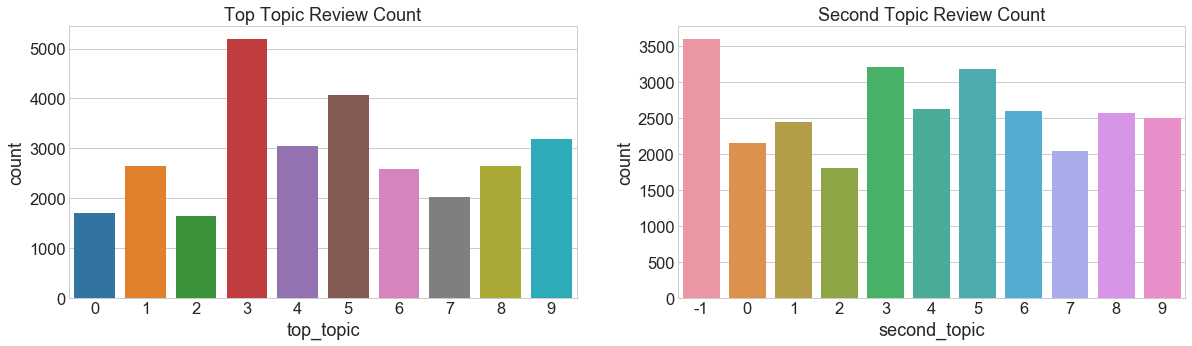

In [15]:
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.style.use('seaborn-whitegrid')

fig = plt.figure(figsize=(20,5))

ax = fig.add_subplot(1, 2, 1)
ax = sns.countplot(x="top_topic", data=df_data)
ax.set_title('Top Topic Review Count')

ax = fig.add_subplot(1, 2, 2)
ax = sns.countplot(x="second_topic", data=df_data)
ax.set_title('Second Topic Review Count')

print('-1 count means: There is no second topic.')
print('Total number of reviews:', len(df_data))

In [16]:
# get topic ID and corresponding topic words in a data frame and save as .csv file for further analysis

#select number of topic words to extract from the LDA model
number_of_topic_words = 20

dict_topics = dict(result_lda_model.show_topics(num_topics=num_topics,formatted=False,num_words=number_of_topic_words))

df_topics = pd.DataFrame({'topic': list(dict_topics.keys()), 
                          'topic words': list(dict_topics.values())}, index=range(len(dict_topics)))

df_topics['topic'] = df_topics['topic'].apply(lambda x: 'Topic ' + str(x + 1))
df_topics['topic words'] = df_topics['topic words'].apply(lambda x: str(list(dict(x).keys())))


#save topic words in .csv file for further analysis
df_topics.to_csv(output_folder + "topic_words_POSITIVE_reviews.csv")

df_topics

,topic,topic words
0,Topic 1,"['renovation', 'brand', 'avoid', 'dollar', 'mention', 'management', 'disappointed', 'garage', 'r..."
1,Topic 2,"['loud', 'noisy', 'sound', 'window', 'alarm', 'fire', 'train', 'wake', 'party', 'music', 'finall..."
2,Topic 3,"['bug', 'roach', 'machine', 'cockroach', 'cup', 'crawl', 'bite', 'card', 'carpet', 'notice', 'po..."
3,Topic 4,"['stain', 'sheet', 'carpet', 'hair', 'mold', 'filthy', 'toilet', 'construction', 'disgusting', '..."
4,Topic 5,"['card', 'rude', 'key', 'credit', 'horrible', 'bill', 'terrible', 'lady', 'clerk', 'speak', 'lat..."
5,Topic 6,"['management', 'speak', 'later', 'finally', 'email', 'send', 'happen', 'cancel', 'reserve', 'con..."
6,Topic 7,"['horrible', 'disappointed', 'smoke', 'loud', 'poor', 'date', 'noisy', 'maintenance', 'disappoin..."
7,Topic 8,"['security', 'break', 'dog', 'steal', 'vehicle', 'poor', 'pet', 'report', 'lock', 'police', 'tru..."
8,Topic 9,"['smoking', 'non', 'toilet', 'terrible', 'smoke', 'average', 'resort', 'low', 'poor', 'break', '..."
9,Topic 10,"['ice', 'hair', 'finally', 'sign', 'terrible', 'luggage', 'table', 'shampoo', 'bag', 'min', 'bot..."


In [17]:
# print all words of selected topic from the df_topics data frame
topic = 'Topic 1'
print(df_topics[df_topics['topic'] == topic]['topic words'].iloc[0])

['renovation', 'brand', 'avoid', 'dollar', 'mention', 'management', 'disappointed', 'garage', 'renovate', 'reward', 'low', 'guy', 'executive', 'later', 'average', 'program', 'disappointing', 'stuff', 'bag', 'poor']


# Hotel level analysis

Function to process results so that results are readable by hotel to hotel and from one quarter to another in each hotel.

In [18]:
#data preparation for hotel level analysis
df_data['top_topic'] = df_data['top_topic'].apply(str)
df_data['second_topic'] = df_data['second_topic'].apply(str)

#delete observations with missing date
df_data_Ha = df_data[df_data['py_review_date'].isnull() == False]

In [19]:
def get_quarter_topics (hotel_ID):
    """
    Constructs data frame with lists of top and second topics by each year-quarter
    for the hotel with ID = hotel_ID.
    
    input:
        hotel_ID - as integer, hotel ID 
    output:
        data frame with two columns "top_topics" and "second_topics"
        that have lists(sets) of unique topics mentioned in hotel review each quarter
    """
    #get data related to the selected hotel
    df_tmp = df_data_Ha[df_data_Ha['Hotel_ID'] == hotel_ID]

    #sort hotel data by review date in ascending order
    df_tmp = df_tmp.sort_values(by=['py_review_date'])

    #get list of top topics for each quarter
    df_hotel_topics = df_tmp.groupby('year-quarter').agg({'top_topic': lambda x: ' '.join(x),
                                                          'second_topic': lambda x: ' '.join(x)
                                                         })
    #for each year-quarter select only unique topics in the list of mentioned topics
    df_hotel_topics['top_topic'] = df_hotel_topics['top_topic'].apply(lambda x: set(x.split(' ')))
    df_hotel_topics['second_topic'] = df_hotel_topics['second_topic'].apply(lambda x: set(x.split(' ')))
    
    return df_hotel_topics

In [20]:
#select Hotel ID
hotel_ID = 153

#get topics for each quarter-year 
df = get_quarter_topics(hotel_ID)
print('Topics for Hotel ID:', hotel_ID, '\n\tby quarter')
df

Topics for Hotel ID: 153 
	by quarter


,top_topic,second_topic
year-quarter,,
2013Q2,{7},{-1}
2014Q1,{5},"{7, 2}"
2014Q2,"{1, 4}","{-1, 8}"
2015Q1,{1},{0}
2015Q2,"{5, 2}","{2, 0}"
2015Q3,"{1, 7}","{-1, 6}"
2015Q4,"{5, 0}","{-1, 4}"
2016Q3,"{7, 4}","{7, 4}"
2016Q4,{5},{4}


In [21]:
# save hotel topic table as .csv
df.to_csv(output_folder + str(hotel_ID) + '_negative_topics.csv')

# Topic coherance score
Since gensim LDA model object does not save topic coherence scores with topic IDs in one data object, we need to extract those.

In [22]:
# get topic ID and corresponding topic words
number_of_topic_words = 20

dict_topics = dict(result_lda_model.show_topics(num_topics=num_topics,formatted=False,num_words=number_of_topic_words))

df_topics = pd.DataFrame({'topic': list(dict_topics.keys()), 
                          'topic words': list(dict_topics.values())}, index=range(len(dict_topics)))

df_topics['topic'] = df_topics['topic'].apply(lambda x: 'Topic ' + str(x))
df_topics['topic words'] = df_topics['topic words'].apply(lambda x: str(list(dict(x).keys())))
df_topics

,topic,topic words
0,Topic 0,"['renovation', 'brand', 'avoid', 'dollar', 'mention', 'management', 'disappointed', 'garage', 'r..."
1,Topic 1,"['loud', 'noisy', 'sound', 'window', 'alarm', 'fire', 'train', 'wake', 'party', 'music', 'finall..."
2,Topic 2,"['bug', 'roach', 'machine', 'cockroach', 'cup', 'crawl', 'bite', 'card', 'carpet', 'notice', 'po..."
3,Topic 3,"['stain', 'sheet', 'carpet', 'hair', 'mold', 'filthy', 'toilet', 'construction', 'disgusting', '..."
4,Topic 4,"['card', 'rude', 'key', 'credit', 'horrible', 'bill', 'terrible', 'lady', 'clerk', 'speak', 'lat..."
5,Topic 5,"['management', 'speak', 'later', 'finally', 'email', 'send', 'happen', 'cancel', 'reserve', 'con..."
6,Topic 6,"['horrible', 'disappointed', 'smoke', 'loud', 'poor', 'date', 'noisy', 'maintenance', 'disappoin..."
7,Topic 7,"['security', 'break', 'dog', 'steal', 'vehicle', 'poor', 'pet', 'report', 'lock', 'police', 'tru..."
8,Topic 8,"['smoking', 'non', 'toilet', 'terrible', 'smoke', 'average', 'resort', 'low', 'poor', 'break', '..."
9,Topic 9,"['ice', 'hair', 'finally', 'sign', 'terrible', 'luggage', 'table', 'shampoo', 'bag', 'min', 'bot..."


In [23]:
# get topic words and topic average coherence score
list_tmp = result_lda_model.top_topics(doc_term_matrix, dictionary=dictionary, topn=number_of_topic_words, 
                                       coherence='c_v', texts=df_data['selected_list_of_lemmas'])
list_tmp = [(s,wd) for (wd, s) in list_tmp]
dict_scores = dict(list_tmp)
df_scores = pd.DataFrame({'topic coherence score': list(dict_scores.keys()), 
                          'topic words': list(dict_scores.values())}, index=range(len(dict_scores)))
df_scores['topic words'] = df_scores['topic words'].apply(lambda x: str(list(dict(x).values())))
df_scores.head()

,topic coherence score,topic words
0,0.612566,"['management', 'speak', 'later', 'finally', 'email', 'send', 'happen', 'cancel', 'reserve', 'con..."
1,0.587401,"['stain', 'sheet', 'carpet', 'hair', 'mold', 'filthy', 'toilet', 'construction', 'disgusting', '..."
2,0.572027,"['security', 'break', 'dog', 'steal', 'vehicle', 'poor', 'pet', 'report', 'lock', 'police', 'tru..."
3,0.567206,"['card', 'rude', 'key', 'credit', 'horrible', 'bill', 'terrible', 'lady', 'clerk', 'speak', 'lat..."
4,0.472817,"['bug', 'roach', 'machine', 'cockroach', 'cup', 'crawl', 'bite', 'card', 'carpet', 'notice', 'po..."


In [24]:
# add topic score to the df_topics to distinguish between human interpretable topics and jargons of statistical analysis
# higher the topic coherence, the topic is more human interpretable. 
print('You can assign names to the topics based on the words related to each topic.')
print('Topic coherence score gives you an idea how easy it is to choose Name to a topic.')
df_topics = df_topics.merge(df_scores, on='topic words')
df_topics.sort_values(by='topic coherence score',ascending=False,inplace=True)
df_topics

You can assign names to the topics based on the words related to each topic.
Topic coherence score gives you an idea how easy it is to choose Name to a topic.


,topic,topic words,topic coherence score
5,Topic 5,"['management', 'speak', 'later', 'finally', 'email', 'send', 'happen', 'cancel', 'reserve', 'con...",0.612566
3,Topic 3,"['stain', 'sheet', 'carpet', 'hair', 'mold', 'filthy', 'toilet', 'construction', 'disgusting', '...",0.587401
7,Topic 7,"['security', 'break', 'dog', 'steal', 'vehicle', 'poor', 'pet', 'report', 'lock', 'police', 'tru...",0.572027
4,Topic 4,"['card', 'rude', 'key', 'credit', 'horrible', 'bill', 'terrible', 'lady', 'clerk', 'speak', 'lat...",0.567206
2,Topic 2,"['bug', 'roach', 'machine', 'cockroach', 'cup', 'crawl', 'bite', 'card', 'carpet', 'notice', 'po...",0.472817
1,Topic 1,"['loud', 'noisy', 'sound', 'window', 'alarm', 'fire', 'train', 'wake', 'party', 'music', 'finall...",0.461942
9,Topic 9,"['ice', 'hair', 'finally', 'sign', 'terrible', 'luggage', 'table', 'shampoo', 'bag', 'min', 'bot...",0.457602
6,Topic 6,"['horrible', 'disappointed', 'smoke', 'loud', 'poor', 'date', 'noisy', 'maintenance', 'disappoin...",0.376085
0,Topic 0,"['renovation', 'brand', 'avoid', 'dollar', 'mention', 'management', 'disappointed', 'garage', 'r...",0.369315
8,Topic 8,"['smoking', 'non', 'toilet', 'terrible', 'smoke', 'average', 'resort', 'low', 'poor', 'break', '...",0.341289


In [26]:
# save topics topic table as .csv
df_topics.to_csv(output_folder + 'coherence_scores_negative_topics.csv')